<a href="https://colab.research.google.com/github/is-leeroy-jenkins/Boo/blob/main/ipynb/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAS Analytics

In [411]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ( LinearRegression, Ridge, RidgeClassifier, LogisticRegression,
                                   BayesianRidge, SGDRegressor, SGDClassifier,
                                   Lasso, ElasticNet, BayesianRidge, HuberRegressor )
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_classification
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor,
                              GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor,
                              HistGradientBoostingClassifier, HistGradientBoostingRegressor )
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

import statsmodels.api as sm
from statsmodels.formula.api import ols

from openai import OpenAI

import warnings

In [3]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

#### Data Source
- File A (Account Balances) published monthly by agencies on [USASpending](https://www.usaspending.gov/federal_account)
- Required by the DATA Act.
- Pulled automatically from data in the [Governmentwide Treasury Account Symbol Adjusted Trial Balance System (GTAS)](https://fiscal.treasury.gov/gtas/)
- Contains Budgetary resources, obligation, and outlay data for all the relevant Treasury Account Symbols (TAS) in a reporting agency.
- It includes both award and non-award spending (grouped together), and crosswalks with the [SF 133 report](https://portal.max.gov/portal/document/SF133/Budget/FACTS%20II%20-%20SF%20133%20Report%20on%20Budget%20Execution%20and%20Budgetary%20Resources.html).



### 📊 Descriptive Statistics
___
| Statistic         | Description                             | Use in Budget Analysis                                               |
|------------------|-----------------------------------------|----------------------------------------------------------------------|
| **Mean**         | Average value                           | Avg. `Outlays`, `Obligations`, etc., across accounts                |
| **Median**       | Middle value                            | Robust central tendency in skewed financial data                    |
| **Mode**         | Most frequent value                     | Identify common `MainAccountCodes` or `Availability` categories     |
| **Standard Deviation** | Spread around the mean                | Indicates variability in execution rates or balances                |
| **Variance**     | Square of standard deviation            | Used in statistical tests and model diagnostics                     |
| **Range**        | Difference between max and min          | Measures total spread of financial metrics                          |
| **Interquartile Range (IQR)** | Spread of middle 50% of data           | Identifies budget outliers and extreme accounts                     |
| **Skewness**     | Asymmetry of distribution               | Skewed obligations suggest few accounts dominate totals             |
| **Kurtosis**     | "Peakedness" of distribution            | High values indicate outlier-prone financial data                   |


### Balances Dataset

In [171]:
# Load the Excel file
file_path_balances = r'C:\Users\terry\Desktop\Account Balances.xlsx'
df_balances = pd.read_excel( file_path_balances, sheet_name = 'Data' )
numeric_columns = [ 'CarryoverAuthority', 'CarryoverAdjustments', 'AnnualAppropriations',
                    'BorrowingAuthority', 'ContractAuthority', 'OffsettingReceipts',
                    'Obligations', 'Recoveries', 'UnobligatedBalance', 'Outlays', 'TotalResources' ]
subset_columns = [ 'AnnualAppropriations', 'CarryoverAuthority', 'UnobligatedBalance',
                   'Obligations', 'Outlays' ]

# Filter data
all = [ 'AccountBalancesId', 'AgencyIdentifier', 'AgencyName', 'BeginningPeriodOfAvailability',
        'EndingPeriodOfAvailablity', 'Availability', 'MainAccountCode', 'SubAccountCode',
        'TreasuryAccountSymbol', 'TreasuryAccountName', 'BudgetFunction', 'BudgetSubFunction',
        'FederalAccountSymbol', 'FederalAccountName', 'LastModified',
        'SubmissionPeriod' ] + numeric_columns
subset = [ 'AgencyName', 'BudgetFunction' ] + subset_columns

# Define complete dataset
df_dataset = df_balances[ all ].fillna( 0 )
df_subset = df_balances[ subset ].fillna( 0 )
df_numeric = df_balances[ numeric_columns ].fillna( 0 )

# Convert fiscal year columns to numeric
df_dataset.iloc[ :, 5: ] = df_dataset.iloc[ :, 5: ].apply( pd.to_numeric, errors = 'coerce' )

print( hdr )
print( 'Descriptive Statistics - Balances Dataset' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_dataset[ numeric_columns ].describe( percentiles=[ .25, .5, .75 ] )

df_descriptive.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics - Balances Dataset




,CarryoverAuthority,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
count,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04,5.698700e+04
mean,2.236022e+08,1.670400e+07,9.640120e+08,5.143275e+06,2.341911e+07,5.658304e+07,1.044334e+09,2.671504e+07,2.451300e+08,1.002847e+09,1.289464e+09
std,4.410790e+09,9.209870e+08,1.926234e+10,3.624667e+08,1.010791e+09,1.118463e+09,1.907602e+10,6.600979e+08,4.591571e+09,1.872748e+10,1.995196e+10
min,-1.243823e+10,-1.069944e+11,-4.778902e+11,0.000000e+00,-1.653946e+07,-7.315833e+09,-9.230616e+06,-1.885326e+06,-2.344574e+10,-4.726972e+06,-4.288210e+09
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.680000e+00,7.901800e+02,9.932670e+04
50%,4.765065e+05,5.533000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.073116e+05,1.535033e+04,5.543914e+05,1.329503e+06,2.305069e+06
75%,6.926488e+06,7.500632e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115899e+07,1.024507e+06,7.935946e+06,3.053774e+07,3.612729e+07
max,4.681363e+11,1.219471e+11,1.301902e+12,4.569707e+10,1.061979e+11,1.202509e+11,1.301902e+12,7.949705e+10,4.681363e+11,1.293782e+12,1.301902e+12


### 🔍 Inferrential Statistics


| Metric           | Description                                | Use in Budget Analysis                                                  |
|-------------------------|--------------------------------------------|--------------------------------------------------------------------------|
| **Pearson Correlation** | Linear relationship between variables      | E.g., `TotalResources` vs. `Obligations`                                |
| **Spearman Correlation**| Monotonic (rank-based) relationship        | More robust to non-linear trends in financial execution                 |
| **t-test**              | Compare means between 2 groups             | Discretionary vs. Mandatory accounts' execution rates                   |
| **ANOVA**               | Compare means across multiple groups       | `Obligations` across availability periods or account types              |
| **Chi-square Test**     | Categorical independence                   | Is `MainAccountCode` related to `Availability` or agency?              |
| **Confidence Intervals**| Estimate range of a population mean        | Bound expected obligations or recoveries                                |
| **Regression Coefficients (p-values)** | Test variable significance       | Is `Recoveries` a significant predictor of `UnobligatedBalance`?        |
| **F-statistic (overall regression)**   | Test whole model fit             | Determines joint explanatory power of all predictors                    |
| **Z-score / Outlier Tests** | Deviation from standard mean             | Identify abnormal balances or lapse rates                               |
| **Boxplots**            | Visual outlier detection                   | Show obligation anomalies within agencies                               |

___


In [365]:
# Clean and preprocess
df_clean = df_dataset.copy()
cols_to_drop = [
    'AccountBalancesId', 'TreasuryAccountSymbol',
    'TreasuryAccountName', 'LastModified', 'SubmissionPeriod'
]

df_clean.drop( columns=cols_to_drop, inplace=True, errors='ignore' )

# Encode categorical variables
categorical_cols = df_clean.select_dtypes(include='object').columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].astype('category').cat.codes

# Drop rows with missing values for simplicity in inferential analysis
df_clean.dropna( inplace=True )

# Compute correlation matrix
correlation_matrix = df_clean.corr(numeric_only=True).round(3)

# Perform t-tests between high and low execution groups
df_clean['ExecutionRate'] = df_clean['Obligations'] / df_clean['TotalResources']
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna(subset=['ExecutionRate'])
threshold = df_clean['ExecutionRate'].median()
df_clean['HighExecution'] = (df_clean['ExecutionRate'] > threshold).astype(int)

# Update variables list based on correct column names
variables = numeric_columns

# Re-run the t-test loop
ttest_results = []

for var in variables:
    group0 = df_clean[df_clean['HighExecution'] == 0][var]
    group1 = df_clean[df_clean['HighExecution'] == 1][var]
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    ttest_results.append({
        'Variable': var,
        'High-Execution': group0.mean(),
        'Low-Execution': group1.mean(),
        't-Statistic': t_stat,
        'p-Value': p_val
    })

df_ttest = pd.DataFrame(ttest_results).round(2)

print( hdr )
print( 'Inferrential Statistics - Balances Dataset' )
print( nwln )

df_ttest



------------------------------------------------------------------------------------------------------------------------

Inferrential Statistics - Balances Dataset




,Variable,High-Execution,Low-Execution,t-Statistic,p-Value
0,CarryoverAuthority,3.081293e+08,2.005200e+08,2.54,0.01
1,CarryoverAdjustments,2.188164e+06,4.128661e+07,-4.50,0.00
2,AnnualAppropriations,6.416725e+07,2.151566e+09,-11.27,0.00
3,BorrowingAuthority,4.214559e+05,1.139947e+07,-3.15,0.00
4,ContractAuthority,7.834743e+06,4.599033e+07,-3.92,0.00
5,OffsettingReceipts,1.679779e+07,1.133070e+08,-8.97,0.00
6,Obligations,2.240429e+07,2.377815e+09,-12.85,0.00
7,Recoveries,1.179524e+07,4.831407e+07,-5.76,0.00
8,UnobligatedBalance,3.771344e+08,1.862547e+08,4.32,0.00
9,Outlays,5.759963e+07,2.245411e+09,-12.15,0.00


### 🧠  Inferrential Results
- All variables are significantly different (p < 0.001) between high and low execution groups.

#### High execution accounts have:
- Higher Outlays and Appropriations (indicating active program spending)
- Lower Unobligated Balances, as expected
- Higher Recoveries, suggesting greater recapture activity (often correlated with larger or more complex programs)

___

In [429]:
df_balances.dropna(subset=['AgencyName', 'Obligations', 'Outlays'], inplace=True)
df = df_balances.drop(columns=[
    'AccountBalancesId', 'TreasuryAccountSymbol', 'TreasuryAccountName',
    'LastModified', 'SubmissionPeriod'
], errors='ignore')

print( hdr )
print( 'Analysis of Outlay Variance' )
print( nwln )

# Filter agencies with sufficient data
agency_counts = df['AgencyName'].value_counts()
valid_agencies = agency_counts[agency_counts > 30].index
df_anova = df[df['AgencyName'].isin(valid_agencies)]

# Perform ANOVA: Outlays ~ AgencyName
model = ols('Outlays ~ C(AgencyName)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table_rounded = anova_table.round(2)

anova_table_rounded


------------------------------------------------------------------------------------------------------------------------

Analysis of Outlay Variance




,sum_sq,df,F,PR(>F)
C(AgencyName),2.922345e+23,80.0,10.5,0.0
Residual,1.966532e+25,56524.0,NaN,NaN


### 📊 ANOVA: Outlays Across Agencies

- Performed a one-way ANOVA to test whether mean Outlays significantly differ across federal agencies with sufficient data (at least 30 records each).
- The F-statistic = 10.5 and p-value ≈ 0.0000 indicate statistically significant differences in outlay levels across agencies.
- We reject the null hypothesis that all agencies have the same average Outlays.
- This suggests agency-specific factors or mission scope meaningfully influence spending execution.



| Source         | Sum of Squares       | df     | F-value | p-value |
|----------------|----------------------|--------|---------|---------|
| Agency Name    | 2.922 × 10²³         | 80     | 10.4996 | 0.0000  |
| Residual       | 1.967 × 10²⁵         | 56,524 | —       | —       |

In [431]:
# Perform ANOVA: Obligations ~ AgencyName
model_obligations = ols('Obligations ~ C(AgencyName)', data=df_anova).fit()
anova_table_obligations = sm.stats.anova_lm(model_obligations, typ=2)
anova_table_obligations_rounded = anova_table_obligations.round(4)
anova_table_obligations

,sum_sq,df,F,PR(>F)
C(AgencyName),2.963039e+23,80.0,10.256357,3.313237e-122
Residual,2.041207e+25,56524.0,NaN,NaN


### 📊 ANOVA: Obligations Across Agencies

- The F-statistic = 10.26 with a p-value < 0.001 indicates significant differences in obligation levels across agencies.
- This supports the conclusion that spending commitments vary materially by agency mission, authority, and execution capacity.

| Source         | Sum of Squares       | df     | F-value | p-value |
|----------------|----------------------|--------|---------|---------|
| Agency Name    | 2.963 × 10²³         | 80     | 10.2564 | 0.0000  |
| Residual       | 2.041 × 10²⁵         | 56,524 | —       | —       |




------------------------------------------------------------------------------------------------------------------------

Obligations




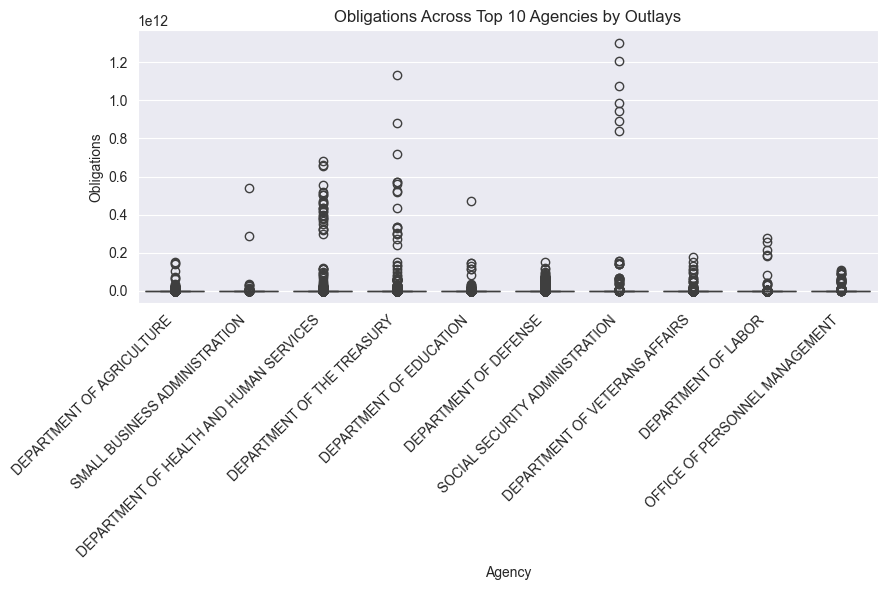

In [433]:
print( hdr )
print( 'Obligations' )
print( nwln )

# Plot: Obligations
plt.figure(figsize=(9, 6))
sns.boxplot(data=filtered_df, x='AgencyName', y='Obligations')
plt.title("Obligations Across Top 10 Agencies by Outlays")
plt.xlabel("Agency")
plt.ylabel("Obligations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



------------------------------------------------------------------------------------------------------------------------

Outlays




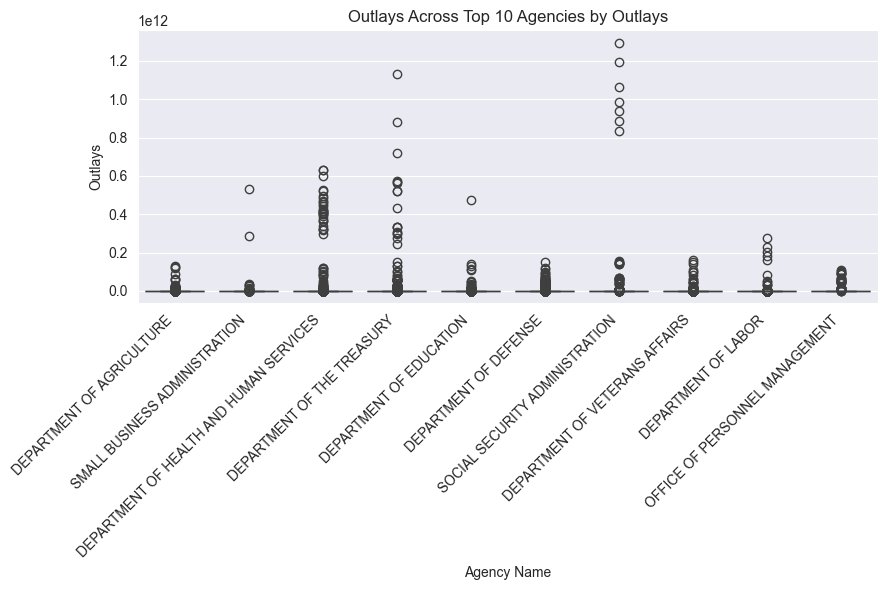

In [432]:
print( hdr )
print( 'Outlays' )
print( nwln )

# Plot: Outlays accross top 10 agencies
plt.figure(figsize=(9, 6))
sns.boxplot(data=filtered_df, x='AgencyName', y='Outlays')
plt.title("Outlays Across Top 10 Agencies by Outlays")
plt.xlabel("Agency Name")
plt.ylabel("Outlays")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Correlational Analysis:

In [382]:
# Display Correlations
print( hdr )
print( 'Correlation Matix' )
print( nwln )

correlation_matrix.fillna(0)


------------------------------------------------------------------------------------------------------------------------

Correlation Matix




,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,SubAccountCode,BudgetFunction,BudgetSubFunction,FederalAccountSymbol,...,CarryoverAdjustments,AnnualAppropriations,BorrowingAuthority,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources
AgencyIdentifier,1.000,0.203,0.006,-0.012,0.0,0.042,-0.025,0.0,0.0,0.0,...,-0.002,-0.010,-0.005,0.002,-0.007,-0.010,-0.004,-0.011,-0.010,-0.012
AgencyName,0.203,1.000,0.031,0.015,0.0,0.024,-0.008,0.0,0.0,0.0,...,-0.004,0.031,0.001,-0.006,0.031,0.032,-0.010,0.009,0.033,0.033
BeginningPeriodOfAvailability,0.006,0.031,1.000,0.901,0.0,0.274,0.094,0.0,0.0,0.0,...,0.020,0.050,0.018,0.030,0.054,0.055,0.028,0.049,0.053,0.064
EndingPeriodOfAvailablity,-0.012,0.015,0.901,1.000,0.0,0.363,0.118,0.0,0.0,0.0,...,0.023,0.055,0.024,0.039,0.063,0.061,0.031,0.059,0.060,0.072
Availability,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
MainAccountCode,0.042,0.024,0.274,0.363,0.0,1.000,0.037,0.0,0.0,0.0,...,0.006,0.040,0.032,0.060,0.062,0.048,0.008,0.021,0.048,0.051
SubAccountCode,-0.025,-0.008,0.094,0.118,0.0,0.037,1.000,0.0,0.0,0.0,...,-0.001,-0.006,-0.002,0.012,0.002,-0.005,-0.002,-0.006,-0.005,-0.006
BudgetFunction,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BudgetSubFunction,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
FederalAccountSymbol,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


---



### 📈 Linear Regression: Actual vs. Predicted

- Assumes a linear relationship between features and the target.
- Useful as a baseline model for comparison with nonlinear methods.
- The scatter pattern around the diagonal helps visualize bias and variance in predictions.
- The plot shows predicted values vs. actual, with the diagonal line representing perfect predictions.
- Most points cluster near the line, suggesting reasonable linear fit for the selected features.


------------------------------------------------------------------------------------------------------------------------

Linear Regression




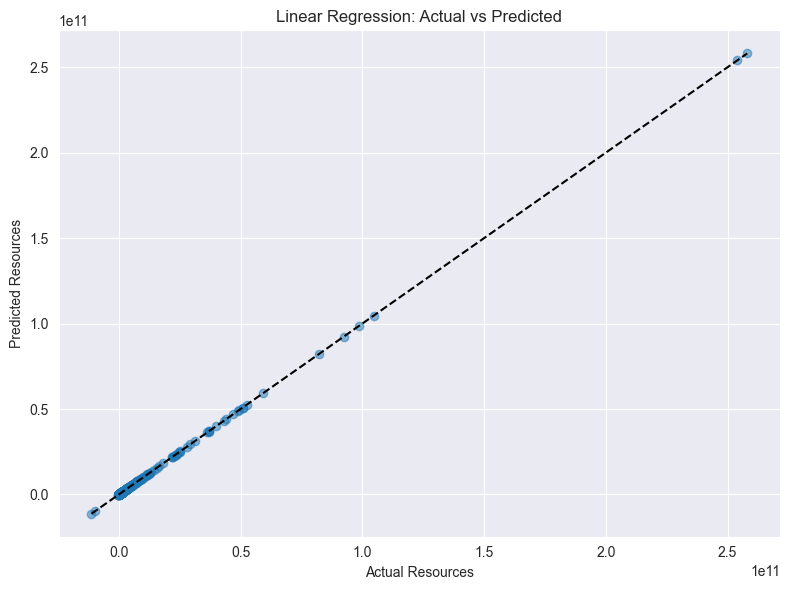

In [259]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric columns for modeling." )

# Prepare data for regression and classification
X = df_numeric.iloc[ :, 1: ]
y_reg = df_numeric.iloc[ :, 0 ]
y_class = (y_reg > y_reg.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Linear regression model
model = LinearRegression()
model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

print( hdr )
print( 'Linear Regression' )
print( nwln )

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Resources")
plt.ylabel("Predicted Resources")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()

###  🌳 Decision Tree Classifier: Confusion Matrix
- This confusion matrix summarizes the performance of a classification tree tasked with predicting whether Outlays are above or below the median.
- It recursively splits the feature space based on information gain (Gini impurity).
- The model performs discrete binary classification and provides easily interpretable decision rules.
- Misclassifications may arise from noise or overfitting, especially without regularization.


------------------------------------------------------------------------------------------------------------------------

Decision-Tree Classifier




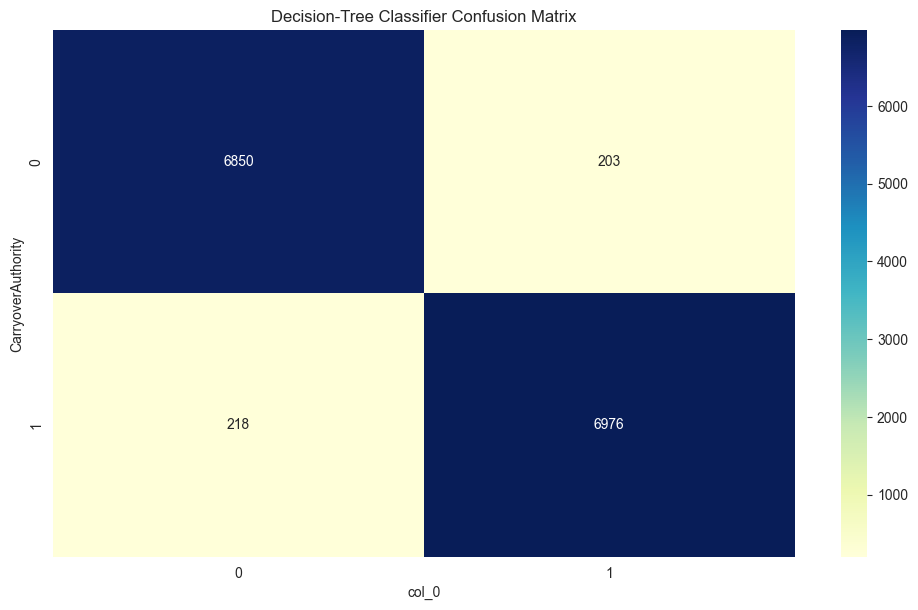

In [258]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric columns for modeling." )

# Prepare data for regression and classification
X = df_numeric.iloc[ :, 1: ]
y_reg = df_numeric.iloc[ :, 0 ]
y_class = (y_reg > y_reg.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

print( hdr )
print( 'Decision-Tree Classifier' )
print( nwln )

# Train, Fit, & Predict
dt_cls = DecisionTreeClassifier(random_state=42)
dt_cls.fit(X_train_class, y_train_class)
y_pred_class = dt_cls.predict(X_test_class)

plt.figure(figsize=(10, 6))
sns.heatmap( pd.crosstab(y_test_class, y_pred_class), annot=True, fmt="d", cmap="YlGnBu" )
plt.tight_layout( )
plt.title("Decision-Tree Classifier Confusion Matrix")
plt.grid( False )
plt.show( )

### 🌳 Decision Tree Regression:
- This plot displays the predictions of a decision tree regression model trained on federal account-level financial data using TotalResources as the target.
- The tree partitions feature space into axis-aligned regions to minimize error in predicting continuous values.
- The vertical scatter seen in the plot reflects the model's nonlinear, piecewise-constant approximation behavior.
- It's interpretable and fast but may overfit if not pruned or tuned.


------------------------------------------------------------------------------------------------------------------------

Decision Tree Regression




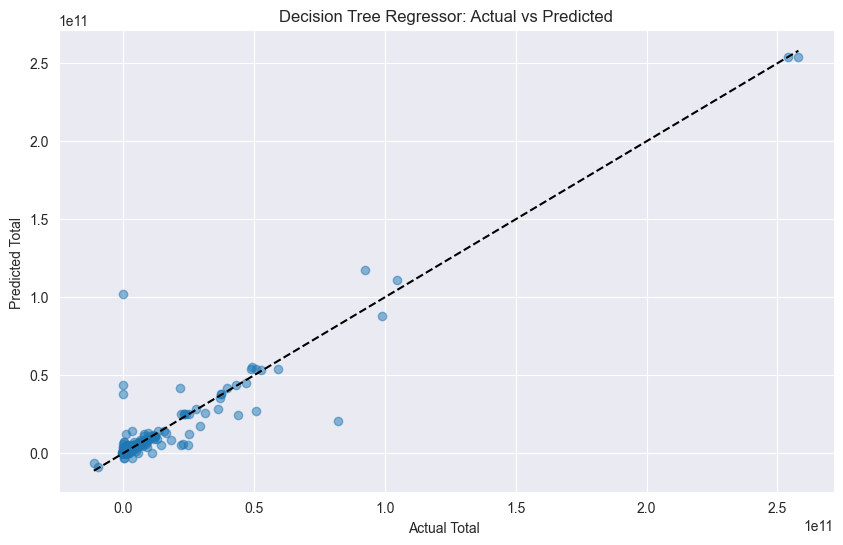

In [261]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

print( hdr )
print( 'Decision Tree Regression' )
print( nwln )

# Regression
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit( X_train_reg, y_train_reg )
y_pred_reg = dt_reg.predict( X_test_reg )

# Plot
plt.figure(figsize=(10, 6))
plt.scatter( y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Total ")
plt.ylabel("Predicted Total ")
plt.title("Decision Tree Regressor: Actual vs Predicted")
plt.grid(True)
plt.show( )


### 🌲 Random Forest Regression:
- This scatterplot shows predictions from a Random Forest Regressor using TotalResources as the target.
- Combines predictions from 100 decision trees to reduce overfitting and improve generalization.
- Produces smooth, non-linear regression surfaces.
- Performs well with modest preprocessing and handles interactions between variables implicitly.


------------------------------------------------------------------------------------------------------------------------

Random Forest Regressor




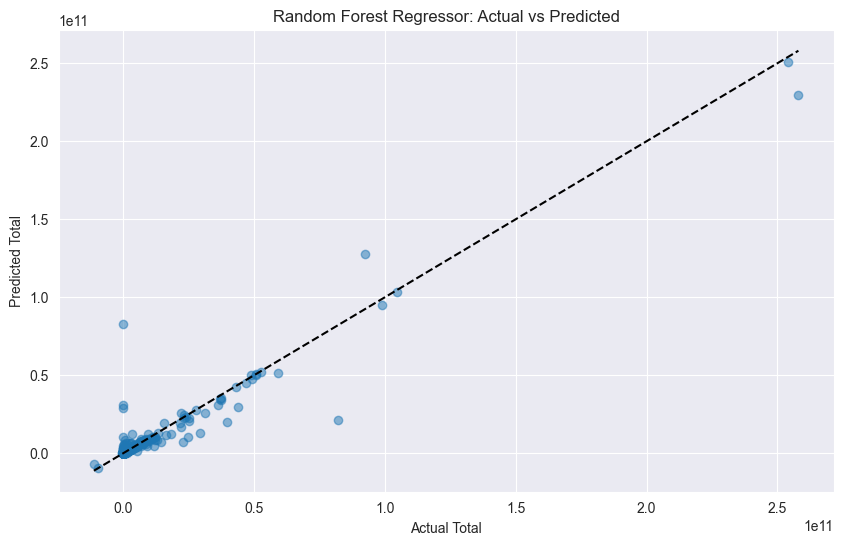

In [262]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

print( hdr )
print( 'Random Forest Regressor' )
print( nwln )

# RandomForestRegressor
rf_reg = RandomForestRegressor( n_estimators=100, random_state=42 )
rf_reg.fit( X_train_reg, y_train_reg )
y_pred_rf_reg = rf_reg.predict( X_test_reg )


plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_rf_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Total")
plt.ylabel("Predicted Total")
plt.title("Random Forest Regressor: Actual vs Predicted")
plt.grid(True)
plt.show( )



### 🌲 Random Forest Classifier:
- This confusion matrix reflects classification performance on predicting whether Outlays are above or below the median.
- Uses majority voting from 100 decision trees for classification.
- Robust to outliers and noise with high accuracy and feature importance insight.
- Diagonal values represent correct classifications.


------------------------------------------------------------------------------------------------------------------------

Classifier




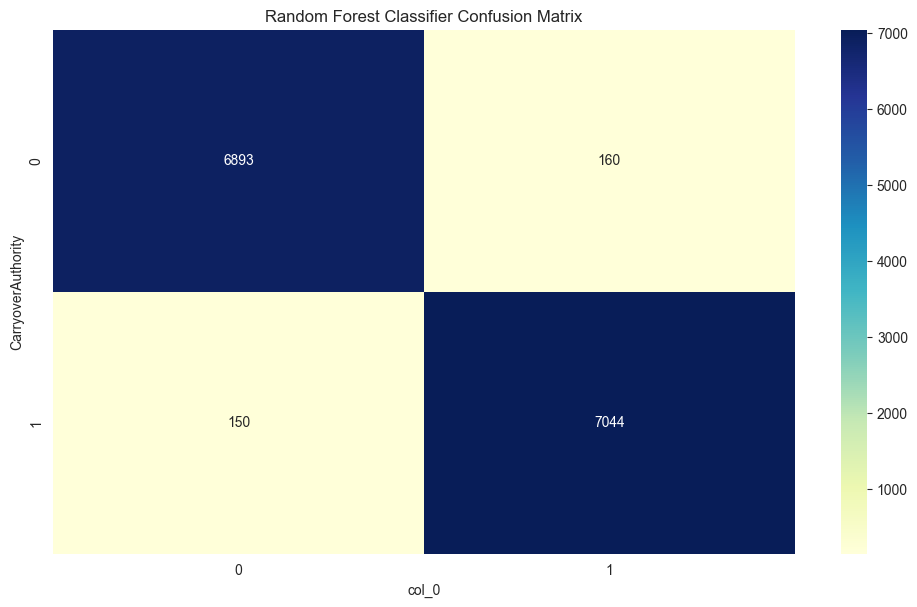

In [263]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# RandomForestClassifier
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit( X_train_class, y_train_class )
y_pred_class = rf_cls.predict( X_test_class )

print( hdr )
print( 'Classifier' )
print( nwln )

plt.figure(figsize=(10, 6))
sns.heatmap( pd.crosstab(y_test_class, y_pred_class), annot=True, fmt="d", cmap="YlGnBu" )
plt.tight_layout( )
plt.title("Random Forest Classifier Confusion Matrix")
plt.grid(False)
plt.show( )

#### 🌳 Extra Trees Classifier: Confusion Matrix
##### This confusion matrix shows classification of Outlays as above or below the median using an Extra Trees Classifier.

- Trained on: Obligations, UnobligatedBalance, Outlays
- Offers high variance reduction and less overfitting due to split randomization.
- Often outperforms conventional trees in predictive accuracy.


------------------------------------------------------------------------------------------------------------------------

Classifier




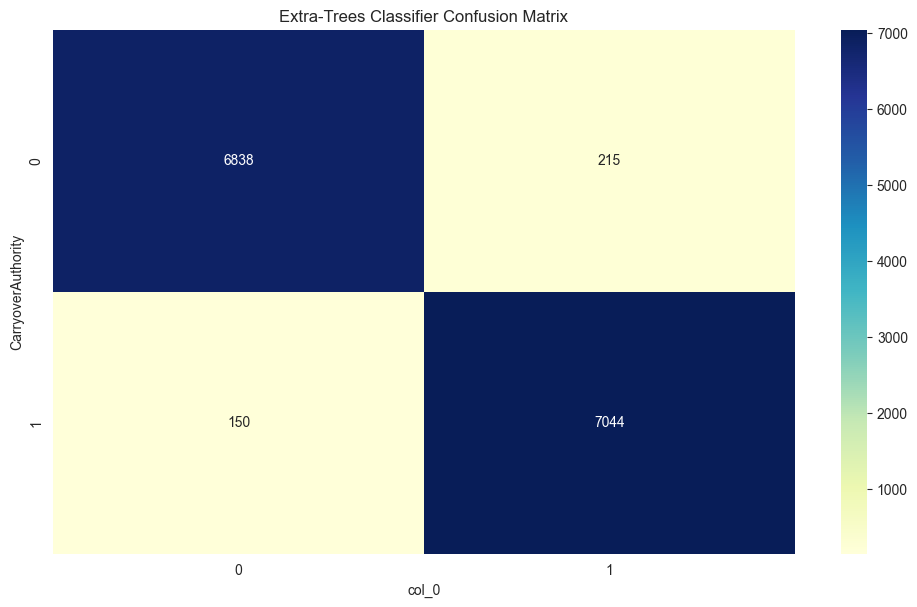

In [266]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )


# ExtraTreesClassifier: Fit & Predict
et_cls = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_cls.fit( X_train_class, y_train_class )
y_pred_class = et_cls.predict( X_test_class )

print( hdr )
print( 'Classifier' )
print( nwln )

plt.figure(figsize=(10, 6))
sns.heatmap( pd.crosstab(y_test_class, y_pred_class), annot=True, fmt="d", cmap="YlGnBu" )
plt.tight_layout( )
plt.title("Extra-Trees Classifier Confusion Matrix")
plt.grid(False)


#### 🌳 Extra Trees Regressorion:
##### This scatterplot illustrates the performance of an Extra Trees Regressor in predicting TotalResources.

- Like Random Forest, but uses random thresholds for splits, increasing variance reduction.
- Aggregates results from 100 fully randomized trees.
- Faster training than standard forests with competitive accuracy.
- Excellent for tabular datasets with many features and low signal-to-noise ratios.


------------------------------------------------------------------------------------------------------------------------

Regression




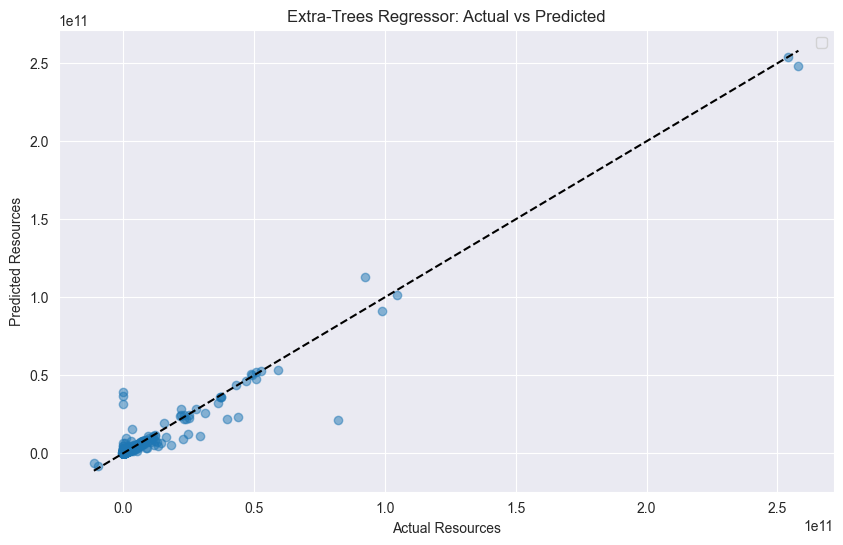

In [267]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# ExtraTreesRegressor : Fit & Predict
et_reg = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_reg.fit(X_train_reg, y_train_reg)
y_pred_et_reg = et_reg.predict(X_test_reg)

print( hdr )
print( 'Regression' )
print( nwln )

plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_et_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Resources")
plt.ylabel("Predicted Resources")
plt.title("Extra-Trees Regressor: Actual vs Predicted")
plt.grid(True)
plt.legend()
plt.show()

#### 🌟 Gradient-Boosting Classifier: Confusion Matrix

- This confusion matrix reflects the performance predicting whether Outlays are above or below the median.
- Sequentially adds trees to improve misclassified samples from earlier iterations.
- Highly effective on imbalanced or noisy classification tasks.
- Performs internal feature selection while minimizing prediction error.
- Slower than Random Forests but often yields better predictive accuracy.


------------------------------------------------------------------------------------------------------------------------

Classifier




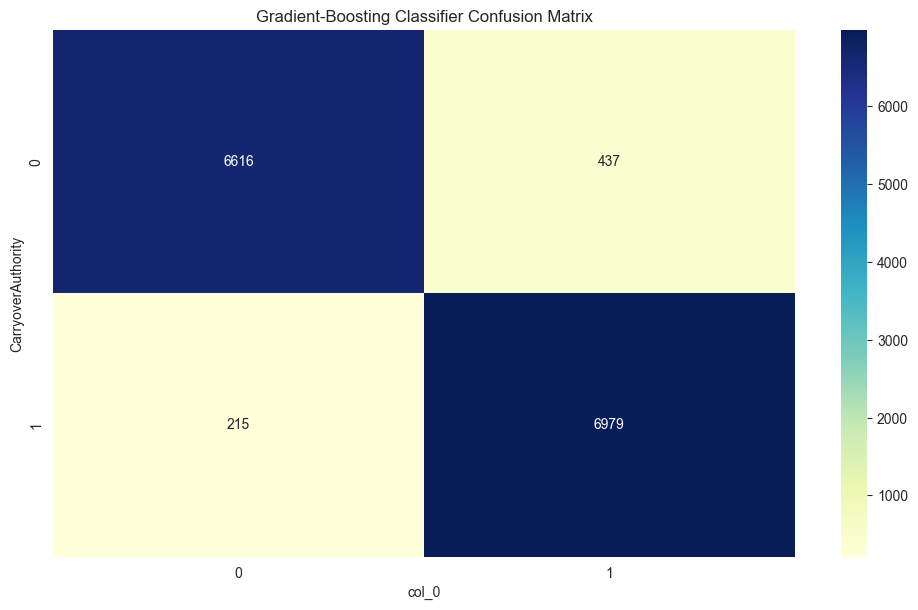

In [268]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )


# Train GradientBoostingClassifier: Fit & Predict
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train_class, y_train_class)
y_pred_class = gb_classifier.predict( X_test_class )

print( hdr )
print( 'Classifier' )
print( nwln )

plt.figure(figsize=(10, 6))
sns.heatmap( pd.crosstab(y_test_class, y_pred_class), annot=True, fmt="d", cmap="YlGnBu" )
plt.tight_layout( )
plt.title("Gradient-Boosting Classifier Confusion Matrix")
plt.grid(False)

#### 🌟 Gradient-Boosting Regression

- This scatterplot visualizes the predictions made by a Gradient Boosting Regressor for TotalResources.
- Builds sequential decision trees, each one correcting the errors of its predecessor.
- Optimizes a loss function (e.g., mean squared error) via gradient descent.
- More accurate and robust than single models, especially for complex, nonlinear relationships.
- Can overfit if not carefully tuned (e.g., learning rate, tree depth).


------------------------------------------------------------------------------------------------------------------------

Regression




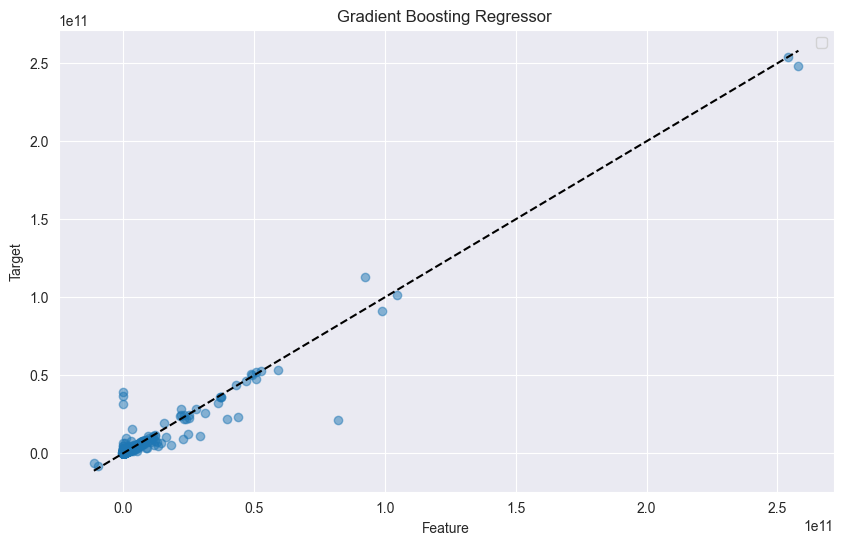

In [269]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Train GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit( X_train_reg, y_train_reg )

# Predict and evaluate
y_pred_gb_reg = gb_regressor.predict(X_test_reg)
mse_gb = mean_squared_error(y_test_reg, gb_regressor.predict(X_test_reg))

print( hdr )
print( 'Regression' )
print( nwln )

# Plot results
plt.figure( figsize=( 8, 6 ) )
plt.scatter(y_test_reg, y_pred_et_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title(f"Gradient-Boosting Regression")
plt.legend()
plt.show()

### 🔢 Ridge Classifier: Confusion Matrix
- This confusion matrix compares the predicted class labels to the actual class labels.
- The Ridge Classifier was trained to classify values above or below the median as binary classes (1 or 0).
- Diagonal values show correct classifications, while off-diagonal values indicate misclassifications.


------------------------------------------------------------------------------------------------------------------------

Classifier




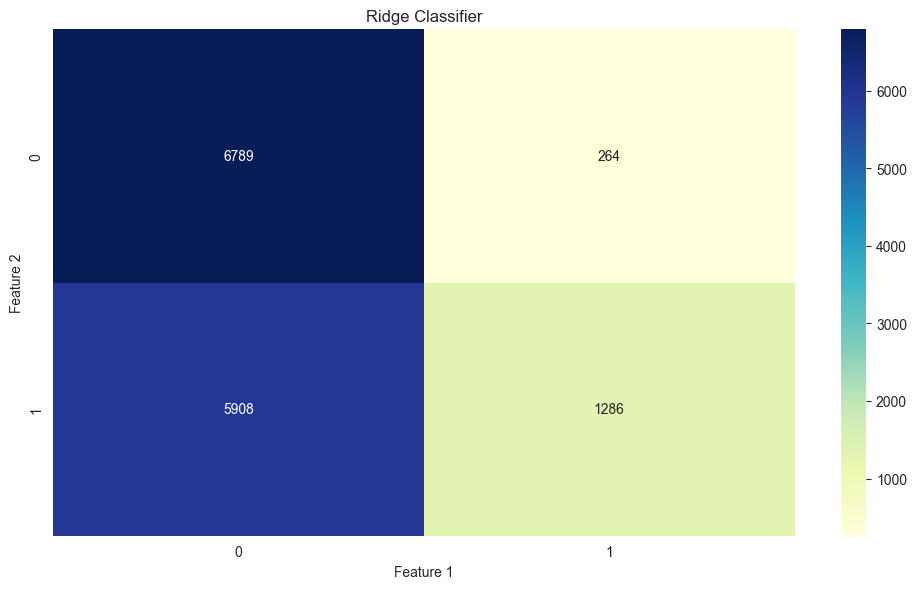

In [270]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Ridge Classifier: Fit & Predict
ridge_clf = RidgeClassifier(alpha=1.0)
ridge_clf.fit(X_train_class, y_train_class)
y_pred_class = ridge_clf.predict(X_test_class)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot Ridge Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_class), annot=True, fmt="d", cmap="YlGnBu")
plt.title(f"Ridge Classifier")
plt.tight_layout()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



### 📊 Ridge Regression
- This scatterplot shows the actual values versus the predicted values from the Ridge Regressor.
- The closer the points are to the diagonal, the better the model's prediction performance.


------------------------------------------------------------------------------------------------------------------------

Regression




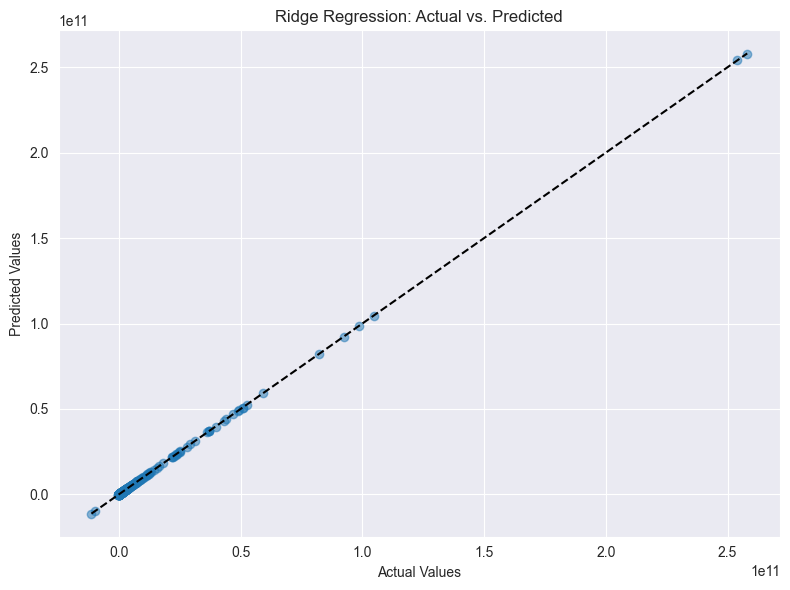

In [327]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42)
_, _, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = ridge_reg.predict(X_test_reg)


print( hdr )
print( 'Regression' )
print( nwln )

# Plot Ridge Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


### 🔢 Stochastic Gradient Descent (SGD) Classifier: Confusion Matrix
- This heatmap shows the performance of the SGD Classifier as it attempts to classify values above or below the median.
- Diagonal cells represent correct predictions; off-diagonal cells show misclassifications.


------------------------------------------------------------------------------------------------------------------------

Classifier




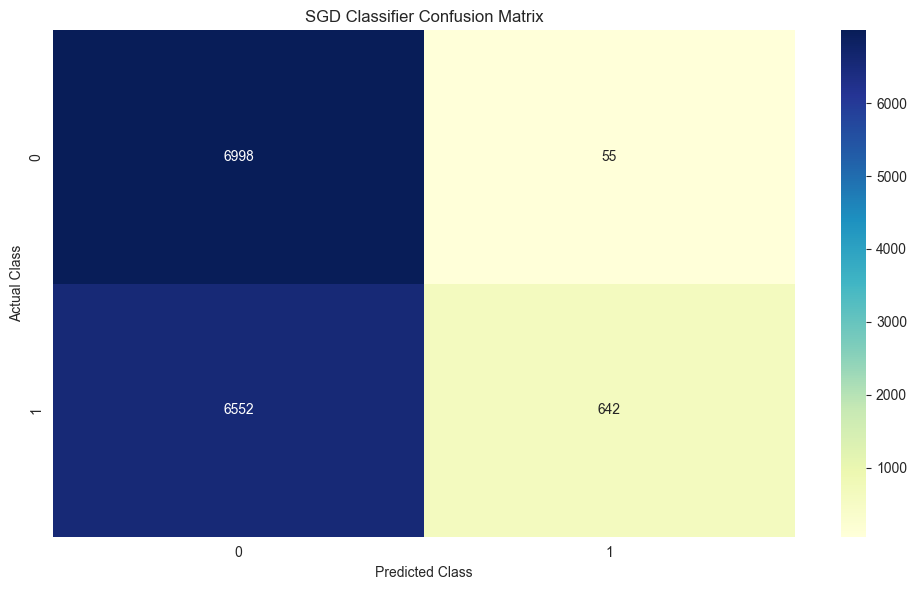

In [292]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

print( hdr )
print( 'Classifier' )
print( nwln )

# SGD Classifier
sgd_clf = SGDClassifier( max_iter=1000, tol=1e-3 )
sgd_clf.fit( X_train_class, y_train_class )
y_pred_sgd_clf = sgd_clf.predict(X_test_class)

# Plot SGD Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_sgd_clf), annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("SGD Classifier Confusion Matrix")
plt.tight_layout()
plt.show()

### 📉 Stochastic Gradient Descent (SGD) Regression:
- This scatterplot displays predicted values against actual values using the Stochastic Gradient Descent Regressor.
- Good for large-scale regression tasks with regularization support (L1, L2).


------------------------------------------------------------------------------------------------------------------------

Regression




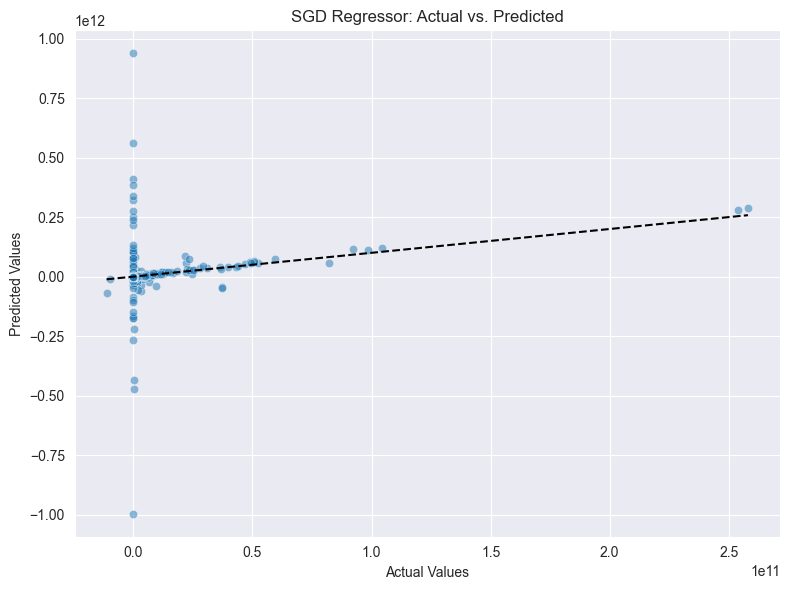

In [330]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )


print( hdr )
print( 'Regression' )
print( nwln )

# Fit & Predict
sgd_reg = SGDRegressor( max_iter=1000, tol=1e-3 )
sgd_reg.fit( X_train_reg, y_train_reg )
y_pred_sgd_reg = sgd_reg.predict(X_test_reg)


# Plot SGD Regressor
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_sgd_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SGD Regressor: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### 📊 Histogram-based Gradient Boosting Classifier: Confusion Matrix
- This heatmap visualizes classification performance when predicting whether values fall above or below the median.
- High diagonal counts imply strong classification performance.


------------------------------------------------------------------------------------------------------------------------

Classifier




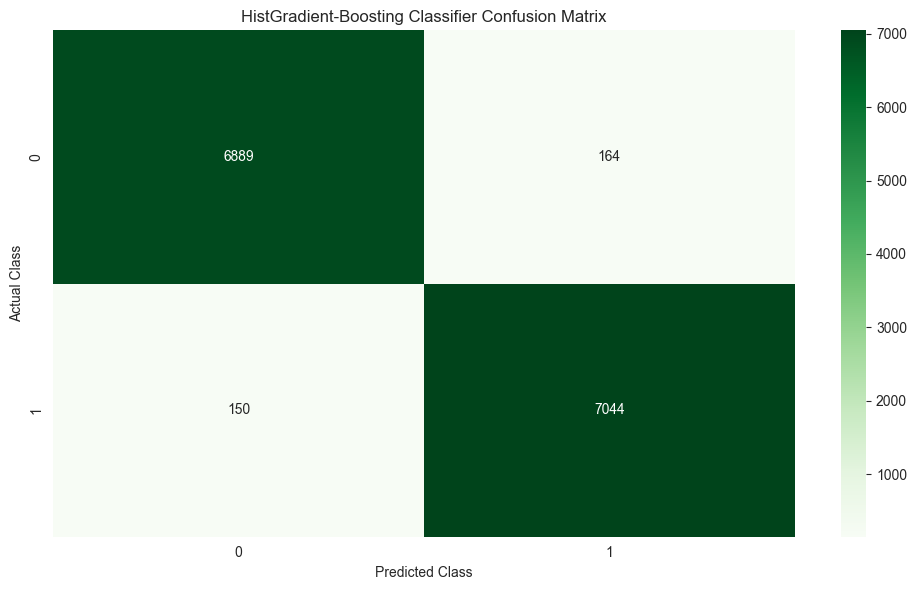

In [281]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )


# HistGradientBoosting Classifier: Fit & Predict
hgb_clf = HistGradientBoostingClassifier(max_iter=100)
hgb_clf.fit(X_train_class, y_train_class)
y_pred_hgb_clf = hgb_clf.predict(X_test_class)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot HistGradientBoosting Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_hgb_clf), annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Histogram-based, Gradient-Boosting Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


### 📊 Histogram-based Gradient Boosting Regression:
- This model applies histogram-based gradient boosting for efficient and scalable regression.
- Ideal for medium to large tabular datasets with strong predictive accuracy.


------------------------------------------------------------------------------------------------------------------------

Regression




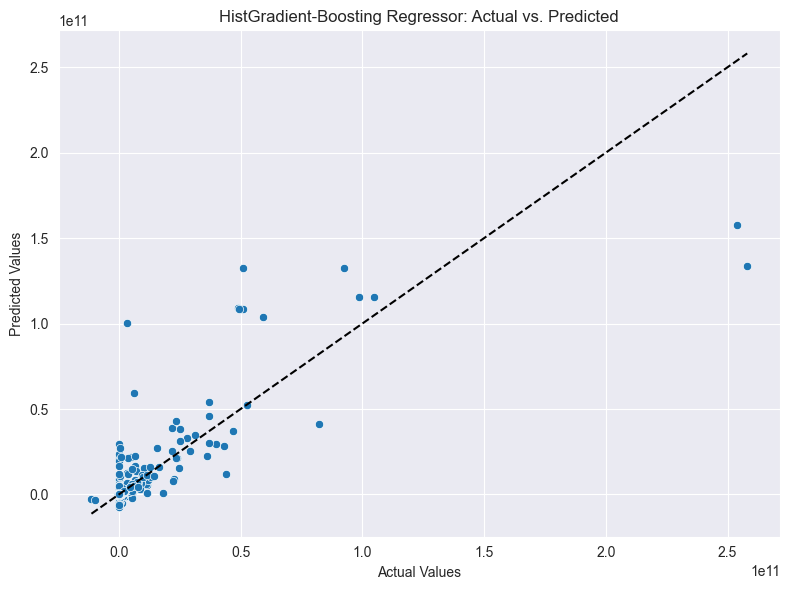

In [331]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# HistGradientBoosting Regressor: Fit & Predict
hgb_reg = HistGradientBoostingRegressor(max_iter=100)
hgb_reg.fit(X_train_reg, y_train_reg)
y_pred_hgb_reg = hgb_reg.predict(X_test_reg)

print( hdr )
print( 'Regression' )
print( nwln )

# Plot HistGradientBoosting Regressor
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_hgb_reg)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Histogram-based, Gradient-Boosting Regression: Actual vs. Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔢 K-Neighbors Classifier:
- This heatmap shows classification performance, identifying whether a value is above or below the median.
- Each prediction is based on a majority vote from the 5 nearest neighbors.


------------------------------------------------------------------------------------------------------------------------

Classifier




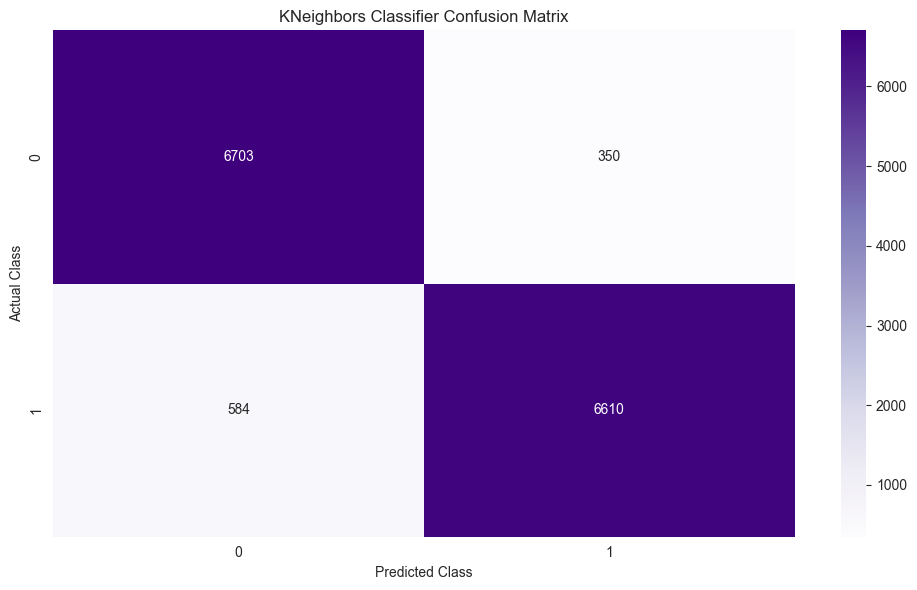

In [294]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )


knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_class, y_train_class)
y_pred_knn_clf = knn_clf.predict(X_test_class)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot KNN Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_knn_clf), annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("K-Neighbors Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


### 📊 K-Neighbors Regression:
- This scatterplot compares actual values to the predicted values using a KNN regressor.
- The model makes predictions by averaging the outputs of the 5 nearest data points in feature space.


------------------------------------------------------------------------------------------------------------------------

Regression




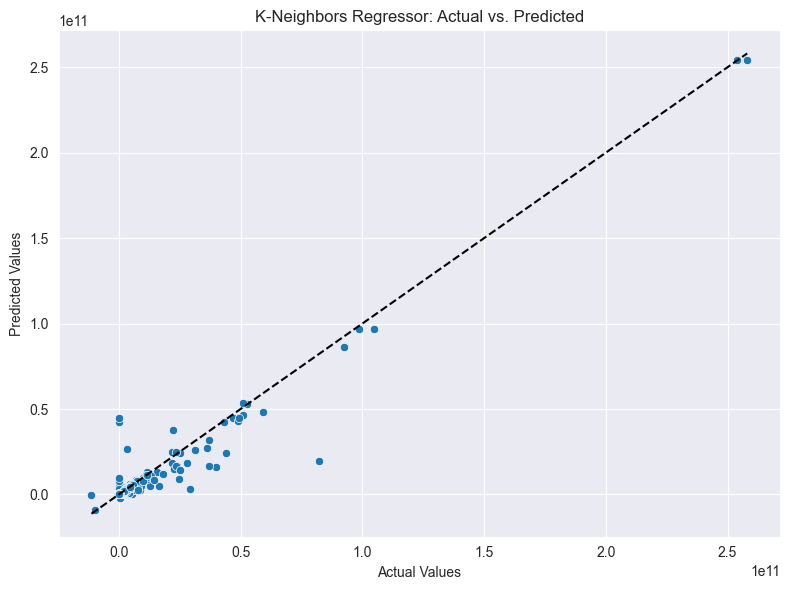

In [332]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Train, fit & predict
knn_reg = KNeighborsRegressor( n_neighbors=5 )
knn_reg.fit( X_train_reg, y_train_reg )
y_pred_knn_reg = knn_reg.predict( X_test_reg )


print( hdr )
print( 'Regression' )
print( nwln )

# Plot KNN Regressor
plt.figure( figsize=( 8, 6 ) )
sns.scatterplot( x=y_test_reg, y=y_pred_knn_reg )
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel( "Actual Values" )
plt.ylabel( "Predicted Values" )
plt.title( "K-Neighbors Regression: Actual vs. Predicted" )
plt.grid( True )
plt.tight_layout( )
plt.show( )


### 🔢 Support Vector Classifier (SVC): Confusion Matrix
- This heatmap visualizes how well SVC classifies values above or below the median.
- SVC constructs hyperplanes in a high-dimensional space to separate the classes.


------------------------------------------------------------------------------------------------------------------------

Classifier




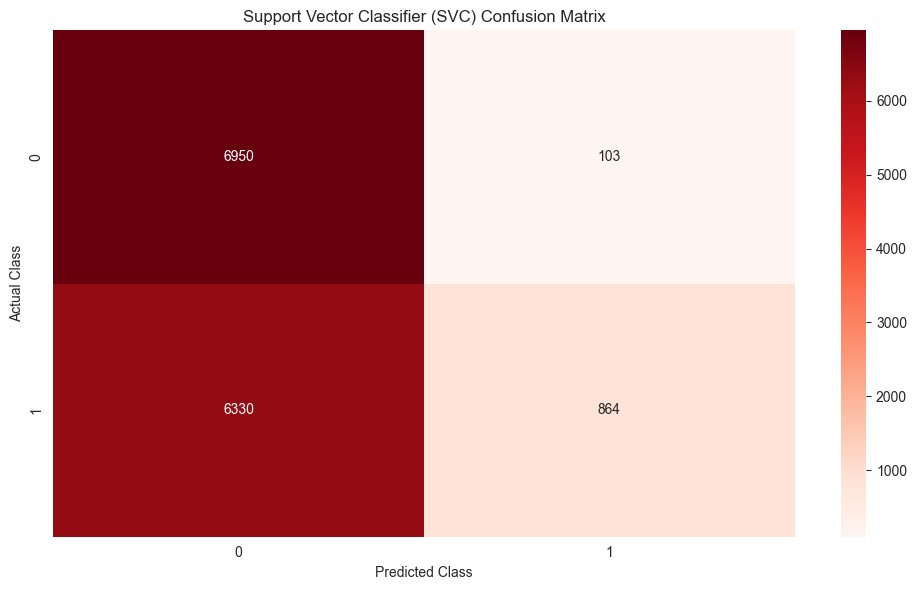

In [296]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )


# Support Vector Classifier
svc_model = SVC( kernel='rbf' )
svc_model.fit( X_train_class, y_train_class )
y_pred_svc = svc_model.predict( X_test_class )

print( hdr )
print( 'Classifier' )
print( nwln )


# Plot SVC
plt.figure( figsize=( 10, 6 ) )
sns.heatmap( pd.crosstab( y_test_class, y_pred_svc ), annot=True, fmt="d", cmap="Reds" )
plt.xlabel( "Predicted Class" )
plt.ylabel( "Actual Class" )
plt.title( "Support Vector Classifier (SVC) Confusion Matrix" )
plt.tight_layout( )
plt.show( )


### 📈 Support Vector Regression (SVR):
- This plot shows how SVR approximates the true values using a non-linear kernel (rbf).
- SVR tries to fit the data within a margin of tolerance rather than minimizing mean squared error directly.


------------------------------------------------------------------------------------------------------------------------

Regression




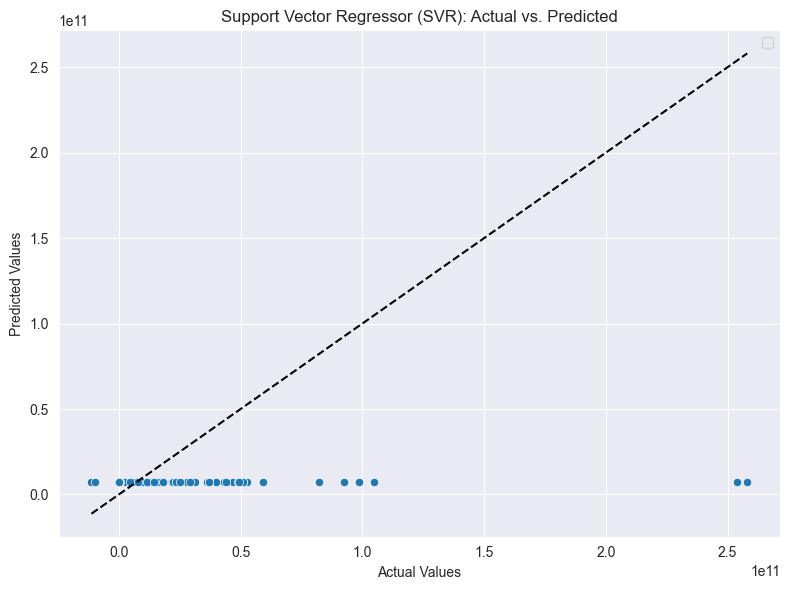

In [337]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Support Vector Regressor: Fit & Predict
svr_model = SVR( kernel='rbf', max_iter=100 )
svr_model.fit( X_train_reg, y_train_reg )
y_pred_svr = svr_model.predict( X_test_reg )

print( hdr )
print( 'Regression' )
print( nwln )

# Plot SVR
plt.figure( figsize=( 8, 6 ) )
sns.scatterplot( x=y_test_reg, y=y_pred_svr )
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel( "Actual Values" )
plt.ylabel( "Predicted Values" )
plt.title( "Support Vector Regressor (SVR): Actual vs. Predicted" )
plt.grid( True )
plt.tight_layout( )
plt.legend( )
plt.show( )



### 🧠 Multi-layer Perceptron (MLP) Classifier (Adjusted):
- Shows how well the MLP Classifier distinguishes values above/below the median.
- Even with early stopping, it achieves a decent classification boundary.


------------------------------------------------------------------------------------------------------------------------

Classifier




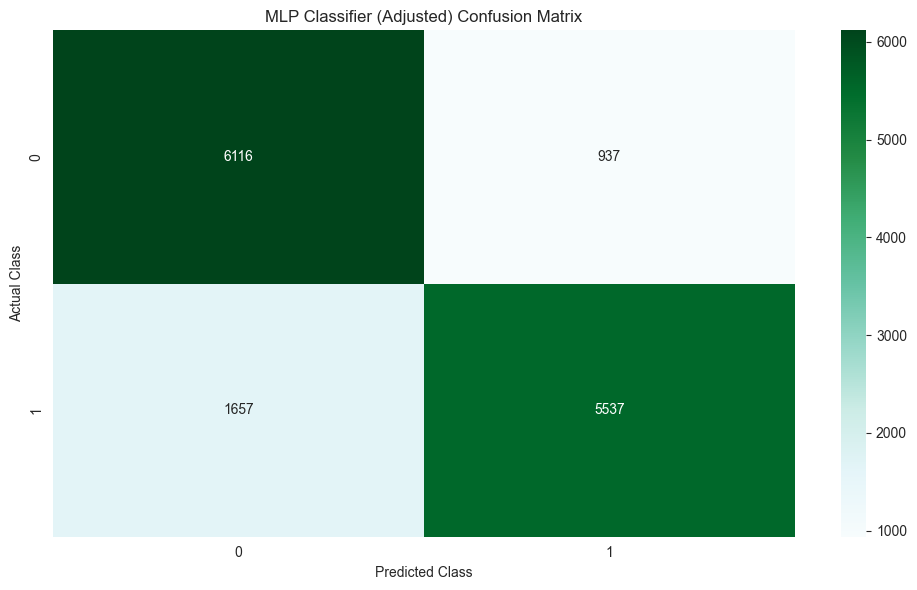

In [301]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

#MLP Classifier: Fit & PredictRetry with simplified model parameters
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, solver='adam', random_state=42)
mlp_clf.fit(X_train_class, y_train_class)
y_pred_mlp_clf = mlp_clf.predict(X_test_class)

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot MLP Classifier
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test_class, y_pred_mlp_clf), annot=True, fmt="d", cmap="BuGn")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("MLP Classifier (Adjusted) Confusion Matrix")
plt.tight_layout()
plt.show()

### 🧠 Multi-layer Perceptron (MLP) Regression (Adjusted):
- The plot shows the predictions of a shallow neural network (1 hidden layer with 50 neurons).
- Although convergence was interrupted, the model offers a rough nonlinear approximation.


------------------------------------------------------------------------------------------------------------------------

Regression




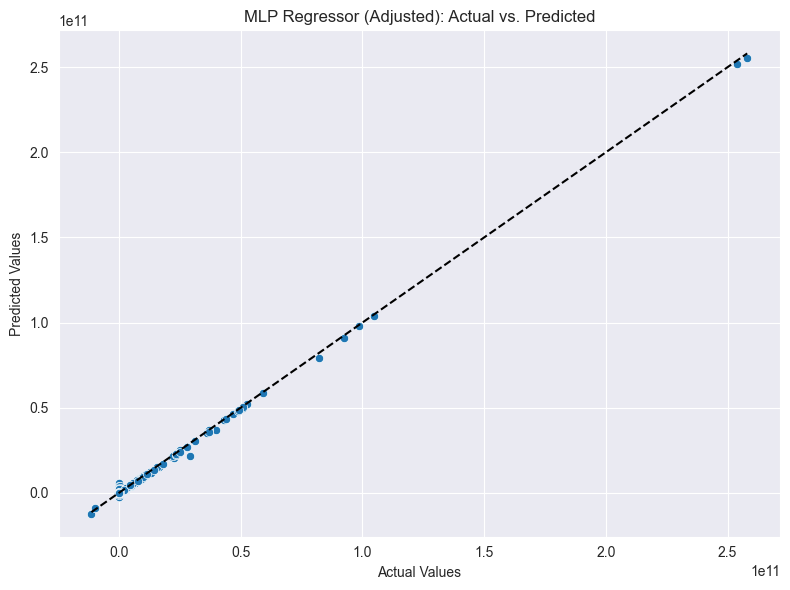

In [338]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

#MLP Classifier: Fit & Predict Retry with simplified model parameters
mlp_reg = MLPRegressor( hidden_layer_sizes=(50,), max_iter=500, solver='adam', random_state=42 )
mlp_reg.fit( X_train_reg, y_train_reg )
y_pred_mlp_reg = mlp_reg.predict( X_test_reg )

print( hdr )
print( 'Regression' )
print( nwln )

# Plot MLP Regressor
plt.figure( figsize=( 8, 6 ) )
sns.scatterplot( x=y_test_reg, y=y_pred_mlp_reg )
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel( "Actual Values" )
plt.ylabel( "Predicted Values" )
plt.title( "Multi-layer Perceptron (MLP) Regression (Adjusted): Actual vs. Predicted" )
plt.grid( True )
plt.tight_layout( )
plt.show( )



### 📘 Gaussian Distribution
- Assumes features follow a normal (Gaussian) distribution.
- Works well with continuous data.
- The confusion matrix shows how well the model separates values above vs. below the median.


------------------------------------------------------------------------------------------------------------------------

Classifier




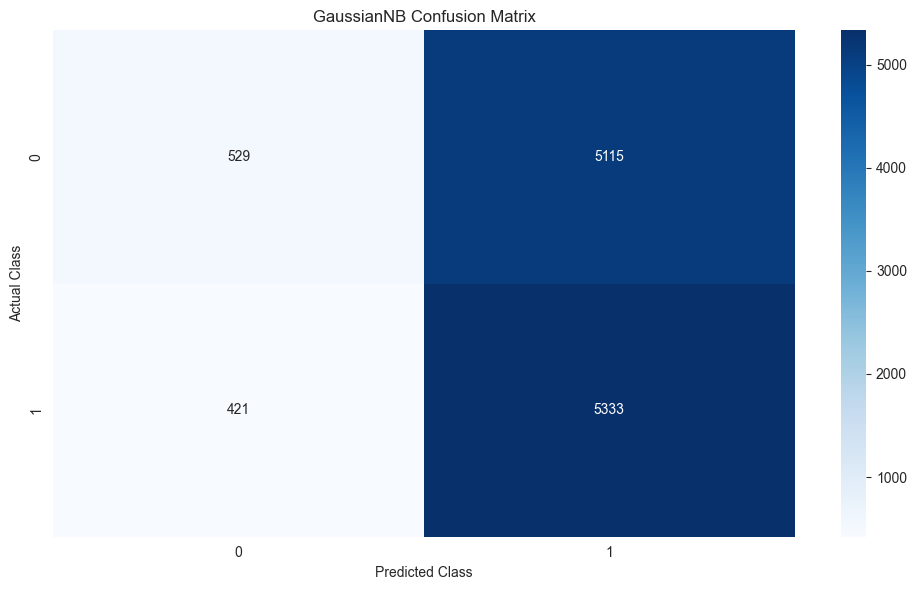

In [47]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Gaussian Naive Bayes Classifier
gnb = GaussianNB( )
gnb.fit( X_train, y_train_class )
y_pred_gnb = gnb.predict( X_test )

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot GaussianNB Classifier
plt.figure( figsize=( 9, 6 ) )
sns.heatmap( pd.crosstab( y_test_class, y_pred_gnb ), annot=True, fmt="d", cmap="Blues" )
plt.xlabel( "Predicted Class" )
plt.ylabel( "Actual Class" )
plt.title( "GaussianNB Confusion Matrix" )
plt.tight_layout( )
plt.show( )


### 🟠 Bernoulli Distribution
- Assumes binary/boolean features (0 or 1).
- Useful for data that can be thresholded into binary states.
- This model may be less appropriate for continuous financial data but is shown for contrast.


------------------------------------------------------------------------------------------------------------------------

Classifier




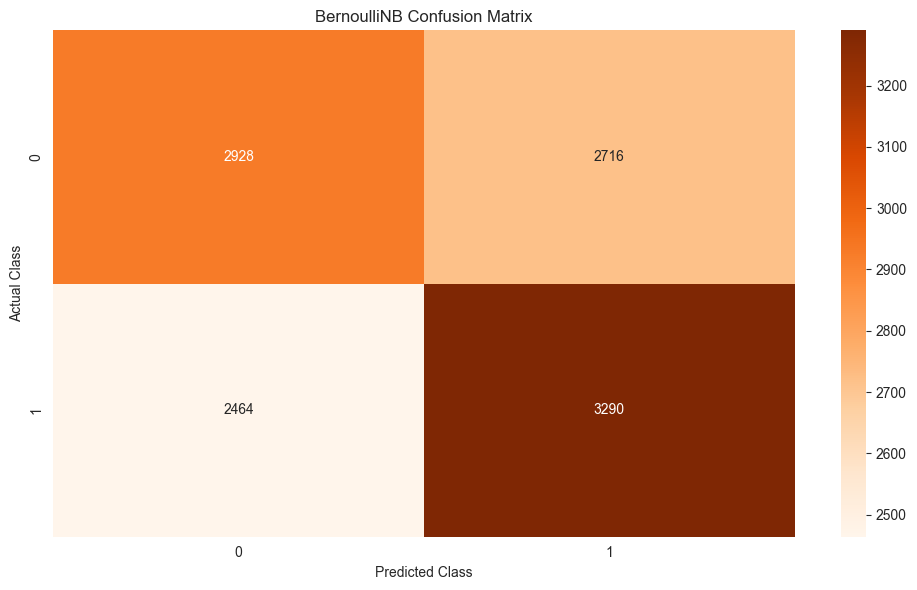

In [48]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )


# Bernoulli Naive Bayes Classifier
bnb = BernoulliNB( )
bnb.fit( X_train, y_train_class )
y_pred_bnb = bnb.predict( X_test )

print( hdr )
print( 'Classifier' )
print( nwln )

# Plot BernoulliNB Classifier
plt.figure( figsize=( 9, 6 ) )
sns.heatmap( pd.crosstab(y_test_class, y_pred_bnb ), annot=True, fmt="d", cmap="Oranges" )
plt.xlabel( "Predicted Class" )
plt.ylabel( "Actual Class" )
plt.title( "BernoulliNB Confusion Matrix" )
plt.tight_layout( )
plt.show( )


### 📌 KMeans Clustering (2D PCA Projection)
- Groups data into 2 clusters using distance-based centroids.
- Visualization uses PCA to reduce dimensions for 2D plotting.
- Points are colored by their assigned cluster labels.




------------------------------------------------------------------------------------------------------------------------

K-Means Classifier




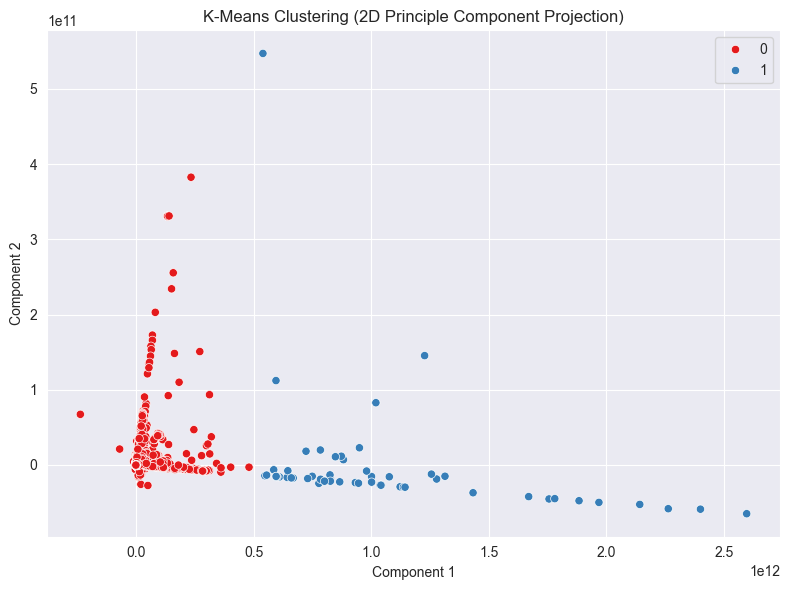

In [406]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Apply PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

print( hdr )
print( 'K-Means Classifier' )
print( nwln )

# Plot KMeans clustering result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="Set1", legend="full")
plt.title("K-Means Clustering (2D Principle Component Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()



### 📌 DBSCAN Clustering (2D-Principle Component Projection)
- A density-based clustering algorithm that groups closely packed points and labels outliers as -1.
- Does not require specifying the number of clusters in advance.
- More robust to irregular cluster shapes and noise.


------------------------------------------------------------------------------------------------------------------------

Classifier




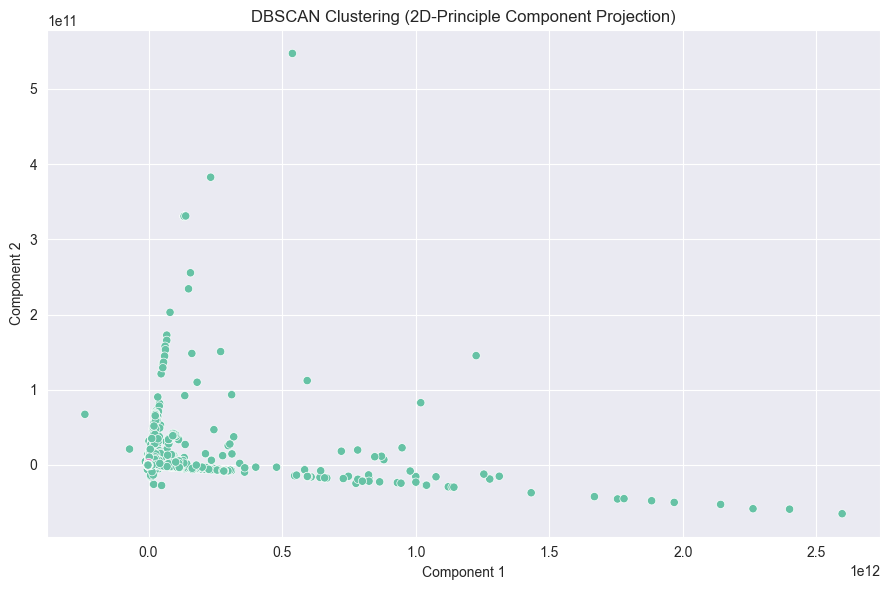

In [405]:
if df_numeric.shape[1] < 2:
    raise ValueError("Not enough numeric columns for modeling.")

# Prepare data for regression and classification
X = df_numeric.iloc[:, 1:]
y_reg = df_numeric.iloc[:, 0]
y_class = (y_reg > y_reg.median()).astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split( X_scaled, y_reg, random_state=42 )
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split( X_scaled, y_class, random_state=42 )

# Apply PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

print( hdr )
print( 'Classifier' )
print( nwln )


# Plot DBSCAN clustering result
plt.figure(figsize=(9, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette="Set2", legend=False)
plt.title("DBSCAN Clustering (2D-Principle Component Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
